[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuropucp/lab-book/blob/main/book/codigoECG.ipynb)

# Análisis de señales ECG

Antes de hacer cualquier proceso, primero deben ejecutar los paquetes (o módulos, o librerías, como deseen llamarlos) en la plataforma. Vamos a instalar los paquetes necesarios:

In [1]:
!pip install neurokit2

Luego de haber instalado los paquetes, los ejecutamos sin problemas.

In [2]:
import neurokit2 as nk
import numpy as np
import pandas as pd


Para esta parte usaremos principalmente el paquete neurokit. NeuroKit ofrece un conjunto de funciones muy útiles que son usados para limpiar, preprocesar y procesar las señales. Uno de ellos es *_process() los cuales incluye:

```
ecg_process()
eda_process()
emg_process()
```
Incluye valores por defecto que deberían ser adecuados para la mayoría de los usuarios y casos de uso típicos. Esta es la sintaxis que es usada para `ecg_process()`

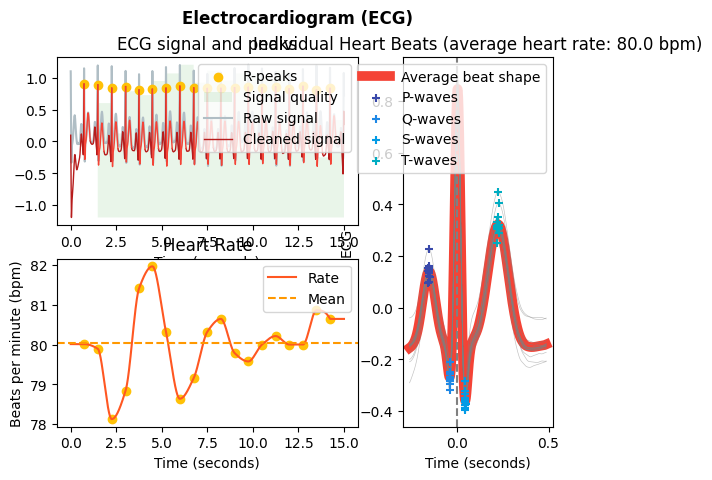

In [3]:
# Simulate ecg signal (caso simulado de ECG, puedes modificarlo para hacer sus pruebas. Presten atención al objeto "ecg" que lo estaré mencionando a lo largo del tutorial)
ecg = nk.ecg_simulate(duration=15, sampling_rate=1000, heart_rate=80)

# Processing pipeline (Por defecto)
signals, info = nk.ecg_process(ecg, sampling_rate=1000)

# Mirar los datos visualizados
nk.ecg_plot(signals, info)

Ahora, el código de ecg_process() puede adaptarse y modificarse a los requerimientos que necesiten. Aquí les paso la función que está detrás del script que me copié de las referencias de Renato:




In [4]:
# Define a new function
def my_processing(ecg_signal):
    # Do processing
    ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000)
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
    rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)


    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})
    signals = pd.concat([signals, instant_peaks], axis=1)

    # Create info dict
    info = rpeaks
    info["sampling_rate"] = 1000
    
    return signals, info

Las modificaciones que hagan a la función se expresarán en el siguiente script: 

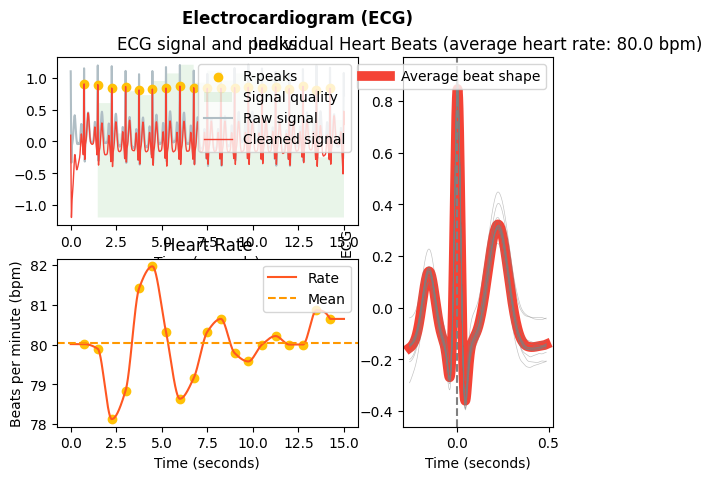

In [5]:
# Procesos usando la definicón
signals, info = my_processing(ecg)

# Visualizar
nk.ecg_plot(signals, info)

Aquí debo explicar algunas cosas para que no malogren la función y que les ayudará a tener datos más ajustados a sus necesidades...


# Métodos de limpieza "ecg_cleaned"

Antes de hacer cualquier proceso, quisiera comentarles algunas métodos que investigué antes de  aplicar los cambios en la función. Si bien todos tienen una explicación bastante profunda, trataré de no detenerme mucho en eso y solo mencionar las bandas de Hz que se usaron en papers o el contexto en el que se aplicaron (también porque mucho no entendí). 

* `neurokit` - El proceso de limpieza por defecto. No investigué más.

* `pantompkins1985` - El primer filtro de banda que reduce el ruido en las mediciones. Actualmente se sigue usando en mediciones de arritmias obteniendo predicciones favorables.

* `hamilton2002` - Por lo que he leído, es un método simplificado del anterior y que también ha sido usado para detección de arritmias. En estudios recientes (digamos 2021 y 2022), he visto que lo usan en mediciones con cortes banda de entre 8 a 16 Hz.

* `elgendi2010` - Este proceso usa el filtro Butterworth en segundo orden con cortes de banda entre 8 a 20 Hz.

* `engzeemod2012` - Este es el más loquito, aplica un filtro Butterworth en cuarto orden y tiene cortes de banda de 48 a 52 Hz. Veo varios estudios de benchmark de señales que lo usan y los comparan con los otros métodos anteriormente explicados.


La verdad, las explicaciones son buenas, los motivo a revisarlas. Lamentablemente, varios de estos documentos cuestan dinero (yo los pude leer con ayuda de Jack Sparrow, guiño guiño). 


Pero bueno, chévere con los métodos, pero ¿cómo los aplico en el script?

Buena pregunta, en la línea `ecg_cleaned` (al cual puse flechas), además del sample_rate, se añade la función method =" " y se detalla el tipo de método de limpieza que quieren aplicar.

```
def my_processing(ecg_signal):
    # Do processing

   --> ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method = "AQUÍ SE PONE EL MÉTODO") <--

    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
    rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)

```

¿No se entendió?, aquí va un ejemplo

In [6]:
# Define a new function
def my_processing(ecg_signal):
    # Do processing
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=1000, method="engzeemod2012")
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
    rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)

    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})
    signals = pd.concat([signals, instant_peaks], axis=1)

    # Create info dict
    info = rpeaks
    info["sampling_rate"] = 1000
    
    return signals, info

Como pueden observar, en la línea de procesamiento de ecg_cleaned agregué la opción "method="engzeemod2012", por lo que aplicará el método ya explicado. Les vuelvo a pasar la función para que puedan ver los cambios:



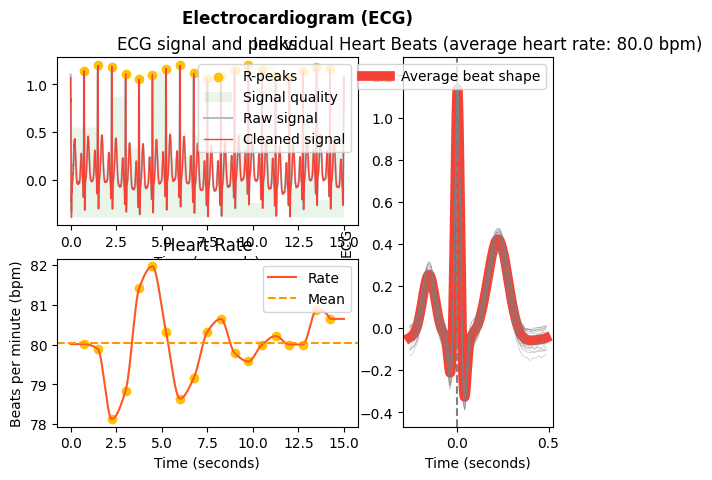

In [7]:
# Procesos usando la definicón con método engzeemod2012
signals, info = my_processing(ecg)

# Visualizar
nk.ecg_plot(signals, info)

Bien, ahora imaginemos que ninguno de estos filtros son lo suficientemente buenos para tu trabajo. Posiblemente tengas problemas limpiando datos por diferentes artefactos; como que tu participante estuvo pateando el cable de tierra durante las pruebas, el asistente que te ayudó en la investigación no sabía cómo poner los electrodos, o tal vez se te ocurrió hacer tus muestras ECG mientras estaban taladrando al costado de tu laboratorio. 

No te preocupes, Neurokit contempla tus necesidades de investigador de tercer mundo, por lo que tienes habilitada las funciones "de bajo nivel" y hacer los cambios que necesites. He aquí un ejemplo:

In [8]:
def my_cleaning(ecg_signal, sampling_rate):
    detrended = nk.signal_detrend(ecg_signal, order=1)
    cleaned = nk.signal_filter(detrended, 
                               sampling_rate=sampling_rate, 
                               lowcut=2, 
                               highcut=9, 
                               method='butterworth')
    return cleaned

Como pueden observar en el ejemplo, aquí hay más detalle de la limpieza. Por un lado, se explicita el tipo de filtro que se va a usar (el tipo 'butterworth', que es usado en los métodos explicados anteriormente), así como los bandas de corte.

```
    cleaned = nk.signal_filter(detrended, 
                               sampling_rate=sampling_rate, 
                               lowcut=2, ---> límite inferior de corte
                               highcut=9, ---> límite superior de corte
                               method='butterworth') ---> filtro utilizado
```



Ahora, teniendo la función personalizada y activa, pasamos a incorporarlo en la función general.


In [9]:
# Define a new function
def my_processing(ecg_signal):
    # Do processing
    ecg_cleaned = my_cleaning(ecg_signal, sampling_rate=1000)
    instant_peaks, rpeaks, = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
    rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)

    # Prepare output
    signals = pd.DataFrame({"ECG_Raw": ecg_signal,
                            "ECG_Clean": ecg_cleaned,
                            "ECG_Rate": rate,
                            "ECG_Quality": quality})

    signals = pd.concat([signals, instant_peaks], axis=1)

    # Create info dict
    info = rpeaks
    info["sampling_rate"] = 1000
    
    return signals, info

In [10]:
signals, info = my_processing(ecg)

In [11]:
signals

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks
0,1.102779,0.095369,80.011854,0.000000,0
1,1.097744,0.069249,80.011854,0.000000,0
2,1.085894,0.042855,80.011854,0.000000,0
3,1.067122,0.016224,80.011854,0.000000,0
4,1.041732,-0.010605,80.011854,0.000000,0
...,...,...,...,...,...
14995,0.933116,-0.010690,80.753701,0.464133,0
14996,0.887910,-0.008716,80.753701,0.464133,0
14997,0.838113,-0.007011,80.753701,0.464133,0
14998,0.784491,-0.005557,80.753701,0.464133,0


In [12]:
info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([  732,  1483,  2252,  3012,  3749,  4481,  5228,  5991,  6750,
         7497,  8241,  8992,  9746, 10496, 11244, 11995, 12744, 13487,
        14230]),
 'sampling_rate': 1000}